# Registration Notebook

### <font color='red'> After clicking on a code cell, press "Shift+Enter" to run the code, or click on the "Run" button in the toolbar above.<br>

### Replace "..." signs with the appropriate path to your data.
</font>

In [1]:
from tapenade import reconstruction
import numpy as np
import tifffile
from pathlib import Path
from tapenade import get_path_to_data

c:\Users\gros\Anaconda3\envs\env-tapenade\lib\site-packages\IO\IO.py:26: UserWarning: KLB library is not installed
  warnings.warn("KLB library is not installed")


pyklb library not found, klb files will not be generated


## Multipositions matching

If you have xml files with the locations of multipositions, you can input them here to plot the positions of all samples and associate the order form the 2 views (in case they are not acquired in the same order)

[1, 2, 3, 4, 5, 6, 7, 8] [5, 4, 6, 3, 2, 8, 1, 7]


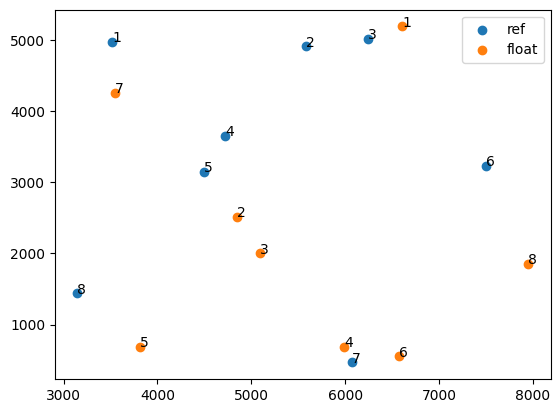

In [ ]:
path_to_data = Path(...)
path_ref_positions = path_to_data / '96h_bottom_multipoints.xml'
path_float_positions = path_to_data / '96h_top_multipoints.xml'

reconstruction.plot_positions(
    path_ref_positions=path_ref_positions,
    path_float_positions=path_float_positions
)
ordered_numbers_ref, ordered_numbers_float=reconstruction.associate_positions(
    path_ref_positions=path_ref_positions,
    path_float_positions=path_float_positions
)

print(ordered_numbers_ref,ordered_numbers_float)

## Paths and channels name

If you used the function associate_positions, you can generate automatically the list_ref and list_float from the number paired above, bottom with top

```list_ref = ["{:01d}_view1".format(i) for i in ordered_numbers_ref]```

```list_float = ["{:01d}_view2".format(i) for i in ordered_numbers_float]```



If you did not use the function associate_positions, you can define the list_ref and list_float manually,

for example with 3 samples and 2 views :

```list_ref=['1_ref','2_ref','3_ref']``` and ```list_float=['1_float','2_float','3_float']```




In [ ]:
# list_ref = ["{:01d}_bottom".format(i) for i in ordered_numbers_ref]
# list_float = ["{:01d}_top".format(i) for i in ordered_numbers_float]
list_ref = ['1_bottom']
list_float = ['5_top']
channels = [
"hoechst",
'ph3',
'bra',
'ecad'
]  # example of channels. If you have only one channel, just put one element in the list

#path where you have your data saved
folder_experiment = Path(...)

## Folder structure
For each sample, 2 tif files, one for each view, with different names and located in the same folder.

Datatype should be int16, uint16 or float32, otherwise no output will be saved.

All files, reference and float, need to be in the folder_experiment

The cell below creates the folder structure necessary for the registration. 


In [ ]:
reconstruction.create_folders(
    folder_experiment= folder_experiment,
    list_ref=list_ref, list_float=list_float, channels=channels
)

## Register automatically

To register your floating image onto the reference one, you should have an idea of the transformation to apply.  From this approximative initial transformation, the algorithm will find the exact transformation to match the 2 sides.

If your image has multiple channels, one will be the reference one, registered first. The second part of the code executes the registration for the other channels, using the same transformation as computed for the reference.

In [6]:
i = 0
filename_ref = list_ref[i]
filename_float = list_float[i]
input_voxel = [0.3,0.3,2] #voxel size of your input image (XYZ) for example [0.6,0.6,1]
output_voxel = [0.3,0.3,2] #voxel size of the output registered image (XYZ), for example [1,1,1]
channel_reference = 'hoechst'  #name of the ubiquitous channel
##if you have a first idea of your tranformations (rotation, translation), you can input them here:
rot= [180,0,0] #XYZ in degrees. ([180,0,0] is a rotation of 180 degrees around the X axis, that we use when flipping the sample)
trans2= [0,0,0] #translation applied after the rotation, XYZ in voxels.


In [ ]:
reconstruction.register(
    path_data=Path(folder_experiment) / filename_ref / "raw",
    path_transformation=Path(folder_experiment) / filename_ref / "trsf",
    path_registered_data=Path(folder_experiment) / filename_ref / "registered",
    reference_image=f"{filename_ref}_{channel_reference}.tif",
    floating_image=f"{filename_float}_{channel_reference}.tif",
    input_voxel=input_voxel,
    output_voxel=output_voxel,
    rot=rot,
    trans2=trans2,
    # input_init_trsf_from_plugin=... #path of the json file saved from the plugin
    save_json=Path(folder_experiment) / filename_ref, #to save all parameters
)

##applying the same transformation to the other channels
for channel in channels :
    if channel != channel_reference:
        reconstruction.register(
            path_data=Path(folder_experiment) / filename_ref / "raw",
            path_transformation =Path(folder_experiment) / filename_ref / "trsf",
            path_registered_data=Path(folder_experiment) / filename_ref / "registered",
            reference_image=f"{filename_ref}_{channel}.tif",
            floating_image=f"{filename_float}_{channel}.tif",
            input_voxel=input_voxel,
            output_voxel=output_voxel,
            compute_trsf=0,
        )

## Napari visualization
(you need to have napari installed)

In [ ]:
try:
    import napari
    napari_installed = True
except ImportError:
    print("napari is not installed, skipping visualization step.")
    napari_installed = False

if napari_installed:
    channel = channel_reference #by default, we visualize using the reference channel but you can replace it here by any other channel
    scale = (output_voxel[2], output_voxel[1], output_voxel[0])
    reconstruction.check_napari(
        folder=Path(folder_experiment)/ f"{filename_ref}",
        reference_image=f"{filename_ref}_{channel}.tif",
        floating_image=f"{filename_float}_{channel}.tif",
        scale=scale,
    )

## Fusion of the two registered images into one image

If it looks well registered, you can now fuse the 2 sides together and fuse the channels to create your new multichannel image.

If you are not satisfied with the registration, adjust the initial transformations (rot, trans1, trans2), you can use the plugin napari-manual-registration to ensure giving accurate input parameters.

In [7]:
for ch in channels:
    image = reconstruction.fuse_sides(
        folder=Path(folder_experiment) / filename_ref,
        reference_image = f"{filename_ref}_{ch}.tif",
        floating_image = f"{filename_float}_{ch}.tif",
        folder_output = Path(folder_experiment) / filename_ref / "fused",
        name_output = f"fusion_{ch}.tif",
        input_voxel = input_voxel,
        output_voxel = output_voxel,
    )

#the result is saved channel by channel in the folder 'fused'.

{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\before_trsf', 'ref_im': 'w_ref.tif', 'flo_ims': ['w_float.tif'], 'compute_trsf': 0, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 0, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.3, 0.3, 2], 'flo_voxels': [[0.3, 0.3, 2]], 'out_voxel': [0.3, 0.3, 2], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\after_trsf', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registration will run with the following arguments:

 File format 
path_to_data             : C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\weights\before_trsf
ref_im               

c:\Users\gros\Anaconda3\envs\env-tapenade\lib\site-packages\registrationtools\spatial_registration.py:169: UserWarning: Testing initial transformations cannot be done when `compute_trsf` is False/0. It will not be done then
  warnings.warn(


{'XResolution': 0.3, 'YResolution': 0.3, 'spacing': 2}
C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\fused\fusion_hoechst.tif (158, 1261, 1210) uint16


C:\Users\gros\Desktop\CODES\tapenade\src\tapenade\reconstruction\_reconstruct.py:772: UserWarning: C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\fused\fusion_hoechst.tif is a low contrast image
  io.imsave(Path(folder_output) / name_output, fusion.astype(dtype_input))


{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\before_trsf', 'ref_im': 'w_ref.tif', 'flo_ims': ['w_float.tif'], 'compute_trsf': 0, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 0, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.3, 0.3, 2], 'flo_voxels': [[0.3, 0.3, 2]], 'out_voxel': [0.3, 0.3, 2], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\after_trsf', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registration will run with the following arguments:

 File format 
path_to_data             : C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\weights\before_trsf
ref_im               

C:\Users\gros\Desktop\CODES\tapenade\src\tapenade\reconstruction\_reconstruct.py:772: UserWarning: C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\fused\fusion_ph3.tif is a low contrast image
  io.imsave(Path(folder_output) / name_output, fusion.astype(dtype_input))


{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\before_trsf', 'ref_im': 'w_ref.tif', 'flo_ims': ['w_float.tif'], 'compute_trsf': 0, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 0, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.3, 0.3, 2], 'flo_voxels': [[0.3, 0.3, 2]], 'out_voxel': [0.3, 0.3, 2], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\after_trsf', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registration will run with the following arguments:

 File format 
path_to_data             : C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\weights\before_trsf
ref_im               

C:\Users\gros\Desktop\CODES\tapenade\src\tapenade\reconstruction\_reconstruct.py:772: UserWarning: C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\fused\fusion_bra.tif is a low contrast image
  io.imsave(Path(folder_output) / name_output, fusion.astype(dtype_input))


{'path_to_data': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\before_trsf', 'ref_im': 'w_ref.tif', 'flo_ims': ['w_float.tif'], 'compute_trsf': 0, 'init_trsfs': [['trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0, 'rot', 'X', 0, 'rot', 'Y', 0, 'rot', 'Z', 0, 'trans', 'X', 0, 'trans', 'Y', 0, 'trans', 'Z', 0]], 'trsf_paths': ['C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\trsf'], 'trsf_types': ['rigid'], 'ref_voxel': [0.3, 0.3, 2], 'flo_voxels': [[0.3, 0.3, 2]], 'out_voxel': [0.3, 0.3, 2], 'test_init': 0, 'apply_trsf': 1, 'out_pattern': 'C:\\Users\\gros\\Desktop\\DATA\\for_revisions\\1_bottom\\weights\\after_trsf', 'begin': 1, 'end': 1, 'bbox_out': 1, 'image_interpolation': 'linear', 'padding': 0, 'registration_depth': 3, 'ordered_init_trsfs': True}
Starting experiment
The registration will run with the following arguments:

 File format 
path_to_data             : C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\weights\before_trsf
ref_im               

C:\Users\gros\Desktop\CODES\tapenade\src\tapenade\reconstruction\_reconstruct.py:772: UserWarning: C:\Users\gros\Desktop\DATA\for_revisions\1_bottom\fused\fusion_ecad.tif is a low contrast image
  io.imsave(Path(folder_output) / name_output, fusion.astype(dtype_input))


## Merge all the channels in one multichannel image

In [8]:
reconstruction.write_hyperstacks(
    path=Path(folder_experiment) / filename_ref / "fused",
    sample_id="fusion",
    channels=channels
)
#the result is saved under the name 'sample_id'_registered.tif in the folder 'fused'.

(158, 1261, 1210)
(158, 1261, 1210)
(158, 1261, 1210)
(158, 1261, 1210)


# Optional : Manual registration without Napari

If the automatic registration is not satisfying, one option is to give more precise initial transformations to the algorithm.

For that, you need to define landmarks, ie features that you recognize in both the reference image and the floating image, that you will need to pinpoint with a marker of given label, this label has to be an integer that has the same value in both image.

Once you have at least 3 annotated landmarks (=3 labels in each image) in a tif image, input them below.
If the result seems good, you can input the initial transformations above ('Register automatically)


In [ ]:
path = ...
filename_ref = ...
filename_float = ...
input_voxel = ...
output_voxel = input_voxel

path_to_landmarks = ...
reference_landmarks = tifffile.imread(
    Path(path_to_landmarks) / f"ref.tif"
)
floating_landmarks = tifffile.imread(
    Path(path_to_landmarks) / f"float.tif"
)
reference_landmarks = reference_landmarks.astype(np.uint16)
floating_landmarks = floating_landmarks.astype(np.uint16)
channel = "hoechst"

rot, trans1, trans2 = reconstruction.manual_registration_fct(
    reference_landmarks=reference_landmarks,
    floating_landmarks=floating_landmarks,
    scale=(input_voxel[2], input_voxel[1], input_voxel[0]),
)
rot=[rot[2],rot[1],rot[0]]

reconstruction.register(
    path_data=Path(path) / filename_ref / "raw",
    path_transformation=Path(path) / filename_ref / "trsf",
    path_registered_data=Path(path) / filename_ref / "registered",
    reference_image=f"{filename_ref}_{channel}.tif",
    floating_image=f"{filename_float}_{channel}.tif",
    input_voxel=input_voxel,  
    output_voxel=output_voxel,
    compute_trsf=1,
    rot=rot,
    trans1=trans1,
    trans2=trans2,
    test_init=0,
    trsf_type="rigid",
    depth=3,
    bbox=1,
    save_json="",
)

print('rot = ',rot,'\ntrans1=',trans1,'\ntrans2=',trans2)